We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add HyperbolicsOECS folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/HyperbolicOECS")

# Overview

In the following notebok we compute hyperbolic objective eulerian coherent structures (hyperbolic OECS) on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO) using the algorithm proposed in [1]. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />

2. Define computational parameters and data.
<br />

3. Define spatio-temporal domain.
<br />

4. Interpolate velocity from the (discrete) gridded data.
<br />

5. Hyperbolic OECS:
    * Compute rate of strain tensor $ \mathbf{S}(\mathbf{x}, t) $ over meshgrid.
    <br />
    
    * Compute eigenvalues $ s_i(\mathbf{x},t) $ and eigenvectors $ e_i(\mathbf{x},t) $ (i = {1,2}) of rate of strain tensor.
    <br />
    
    * Compute the sets of isolated local maxima of $ s_2(\mathbf{x},t) $ (=objective saddle-points)
    <br />
    
    * Compute repelling OECS as tensorlines tangent to the eigenvectors $ \mathbf{e_1}(\mathbf{x}) $ of the rate of strain tensor. The tensorlines are launched from isolated local maxima (objective saddle-points). 's' is a dimensionless dummy time variable.
    <br />
    
    \begin{equation}
    \mathbf{x}'_0(s) = \mathbf{e_1}(\mathbf{x}_0;t)
    \end{equation}
    <br />
    
    * Compute attracting OECS as tensorlines tangent to the eigenvectors $ \mathbf{e_2}(\mathbf{x}) $ of the rate of strain
    <br />
    
    \begin{equation}
    \mathbf{x}'_0(s) = \mathbf{e_2}(\mathbf{x}_0;t)
    \end{equation}
    <br />
    
    * Stop the integration of the tensorlines as soon as $ |s_2(\mathbf{x},t)| $ stops to be monotonically decreasing or $ |s_2(\mathbf{x},t)| < d_{hyperbolicity} $, where $ d_{hyperbolicity} $ is a threshold imposed on the rate of attraction/repulsion (=hyperbolicity) of the attracting/repelling (=hyperbolic) OECS.
<br />    
6. Advect attracting OECS
<br />
7. References

# Import data

In [2]:
# import scipy
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u'][:,:,:]
V = mat_file['v'][:,:,:]
x = mat_file['x'][:,:]
y = mat_file['y'][:,:]
time_data = mat_file['t']

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 7

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# Periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

# Compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

# Resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Time
t_OECS = 0

# store time in array
time = np.array([t_OECS])

# longitudinal and latitudinal boundaries (in degrees)
xmin = 2.75
xmax = 5.5
ymin = -38.25
ymax = -36.4

# make sure that domain is in the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and np.min(time_data) <= t_OECS <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"
    
# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Nx = X_domain.shape[0]
Ny = X_domain.shape[1]

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/10]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy]

# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

# Hyperbolic OECS

## Rate of strain tensor

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The rate of strain tensor at point $ \mathbf{x} $ at time $ t $ is computed from the gradient of the velocity field by using an auxiliary meshgrid.

In [6]:
# Import package for parallel computing
from joblib import delayed, Parallel

# Import function to compute gradient of velocity function
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Split x0, y0 into N (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_S(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])
        
    # Compute gradient of velocity field
    grad_vel = gradient_velocity(t_OECS, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, delta, aux_grid) # (2,2,Nx*Ny)
    
    # Compute rate of strain tensor
    S = .5*(grad_vel+grad_vel.transpose(1,0,2))

    return S

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract rate of strain tensor from results of parallel computation
S = results[0]

for i in range(1,len(results)):
    
    S = np.append(S, results[i], axis = 2)
    
# Reshape array from vectorized form to structured meshgrid
S = S.reshape((2, 2, X_domain.shape[0], X_domain.shape[1]))

## Eigenvalues/Eigenvectors of rate of strain tensor

We now compute the eigenvalues and eigenvectors of the rate of strain tensor

In [8]:
# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

eig1 = S[0,0,:,:].copy()*np.nan
eig2 = S[0,0,:,:].copy()*np.nan
e1 = np.zeros((eig1.shape[0], eig1.shape[1], 2))
e2 = np.zeros((eig2.shape[0], eig2.shape[1], 2))

#iterate over meshgrid
for i in range(X_domain.shape[0]):
    
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # Compute eigenvalues of rate of strain
        eig1[i,j], eig2[i,j], e1[i,j,:], e2[i,j,:] = eigen(S[:,:,i,j])

## Find objective saddles

Objective saddles coincide with local maxima in the maximum eigenvalue field $ s $ of the rate of strain tensor.

In [9]:
# import function to compute local maxima
from ipynb.fs.defs.loc_max import _loc_max

# Minimum distance between objective saddles (=local maxima in the s2-field)
min_distance = .75

# Indices, positions and value (of s2-field) of the objective saddles
loc_idx_x, loc_idx_y, loc_max_x, loc_max_y, loc_max_field = _loc_max(min_distance, X_domain, Y_domain, eig2)

## Shrinklines (Repelling OECS)

Repelling LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \mathbf{e}_1(\mathbf{x}_0;t),
\label{eq: shrinklines}
\end{equation}

with $ \mathbf{e}_1 $ denoting the eigenvector associated to the weakest eigenvalue $ s_1 $ of $ S(\mathbf{x},t) $. The non-orientable vector field is well defined away from tensorline singularities (points where $ s_1 = s_2 $).
The most repelling shrinklines mark initial positions of repelling OECSs. Repelling OECSs can therefore be located as trajectories of eq. \ref{eq: shrinklines} that have locally the largest averaged $ s_2(\mathbf{x},t) $ among all neighbouring shrinklines.

In [10]:
# import function to compute tensorlines
from ipynb.fs.defs.tensorlines import _tensorlines

# step-size used for integration with respect to parameter 's'
step_size = 0.01

# threshold distance to locate local maxima in the 'eig2'-field
max_distance = 0.75

# maximum length of shrinkline
max_length = 5 # this can be set very high if you do not want to place a constraint on the lenght of the stretchline

# Minimum threshold on rate of repulsion of shrinkline 
hyperbolicity = .15

shrinklines = _tensorlines(X_domain, Y_domain, eig2, e1, max_distance, max_length, step_size, hyperbolicity)

## Stretchlines (Attracting OECS)

Attracting LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0 = \mathbf{e}_2(\mathbf{x}_0;t),
\label{eq: stretchlines}
\end{equation}

with $ \mathbf{e}_2 $ denoting the eigenvector associated to the strongest eigenvalue $ s_2 $ of $ S(\mathbf{x},t) $. The non-orientable vector field is well defined away from tensorline singularities (points where $ s_1 = s_2 $).
The most attracting stretchlines mark initial positions of attracting OECSs. Attracting OECSs can therefore be located as trajectories of eq. \ref{eq: stretchlines} that have locally the smallest averaged $ s_1(\mathbf{x},t) $ among all neighbouring stretchlines.

In [11]:
# step-size used for integration with respect to parameter 's'
step_size = 0.01

# threshold distance to locate local minima in the 's_1' field of 'S'
max_distance = 0.75

# maximum length of stretchline
max_length = 5 # this can be set very high if you do not want to place a constraint on the lenght of the stretchline

# Minimum threshold on rate of attraction of stretchline 
hyperbolicity = 0.15

stretchlines = _tensorlines(X_domain, Y_domain, eig2, e2, max_distance, max_length, step_size, hyperbolicity)

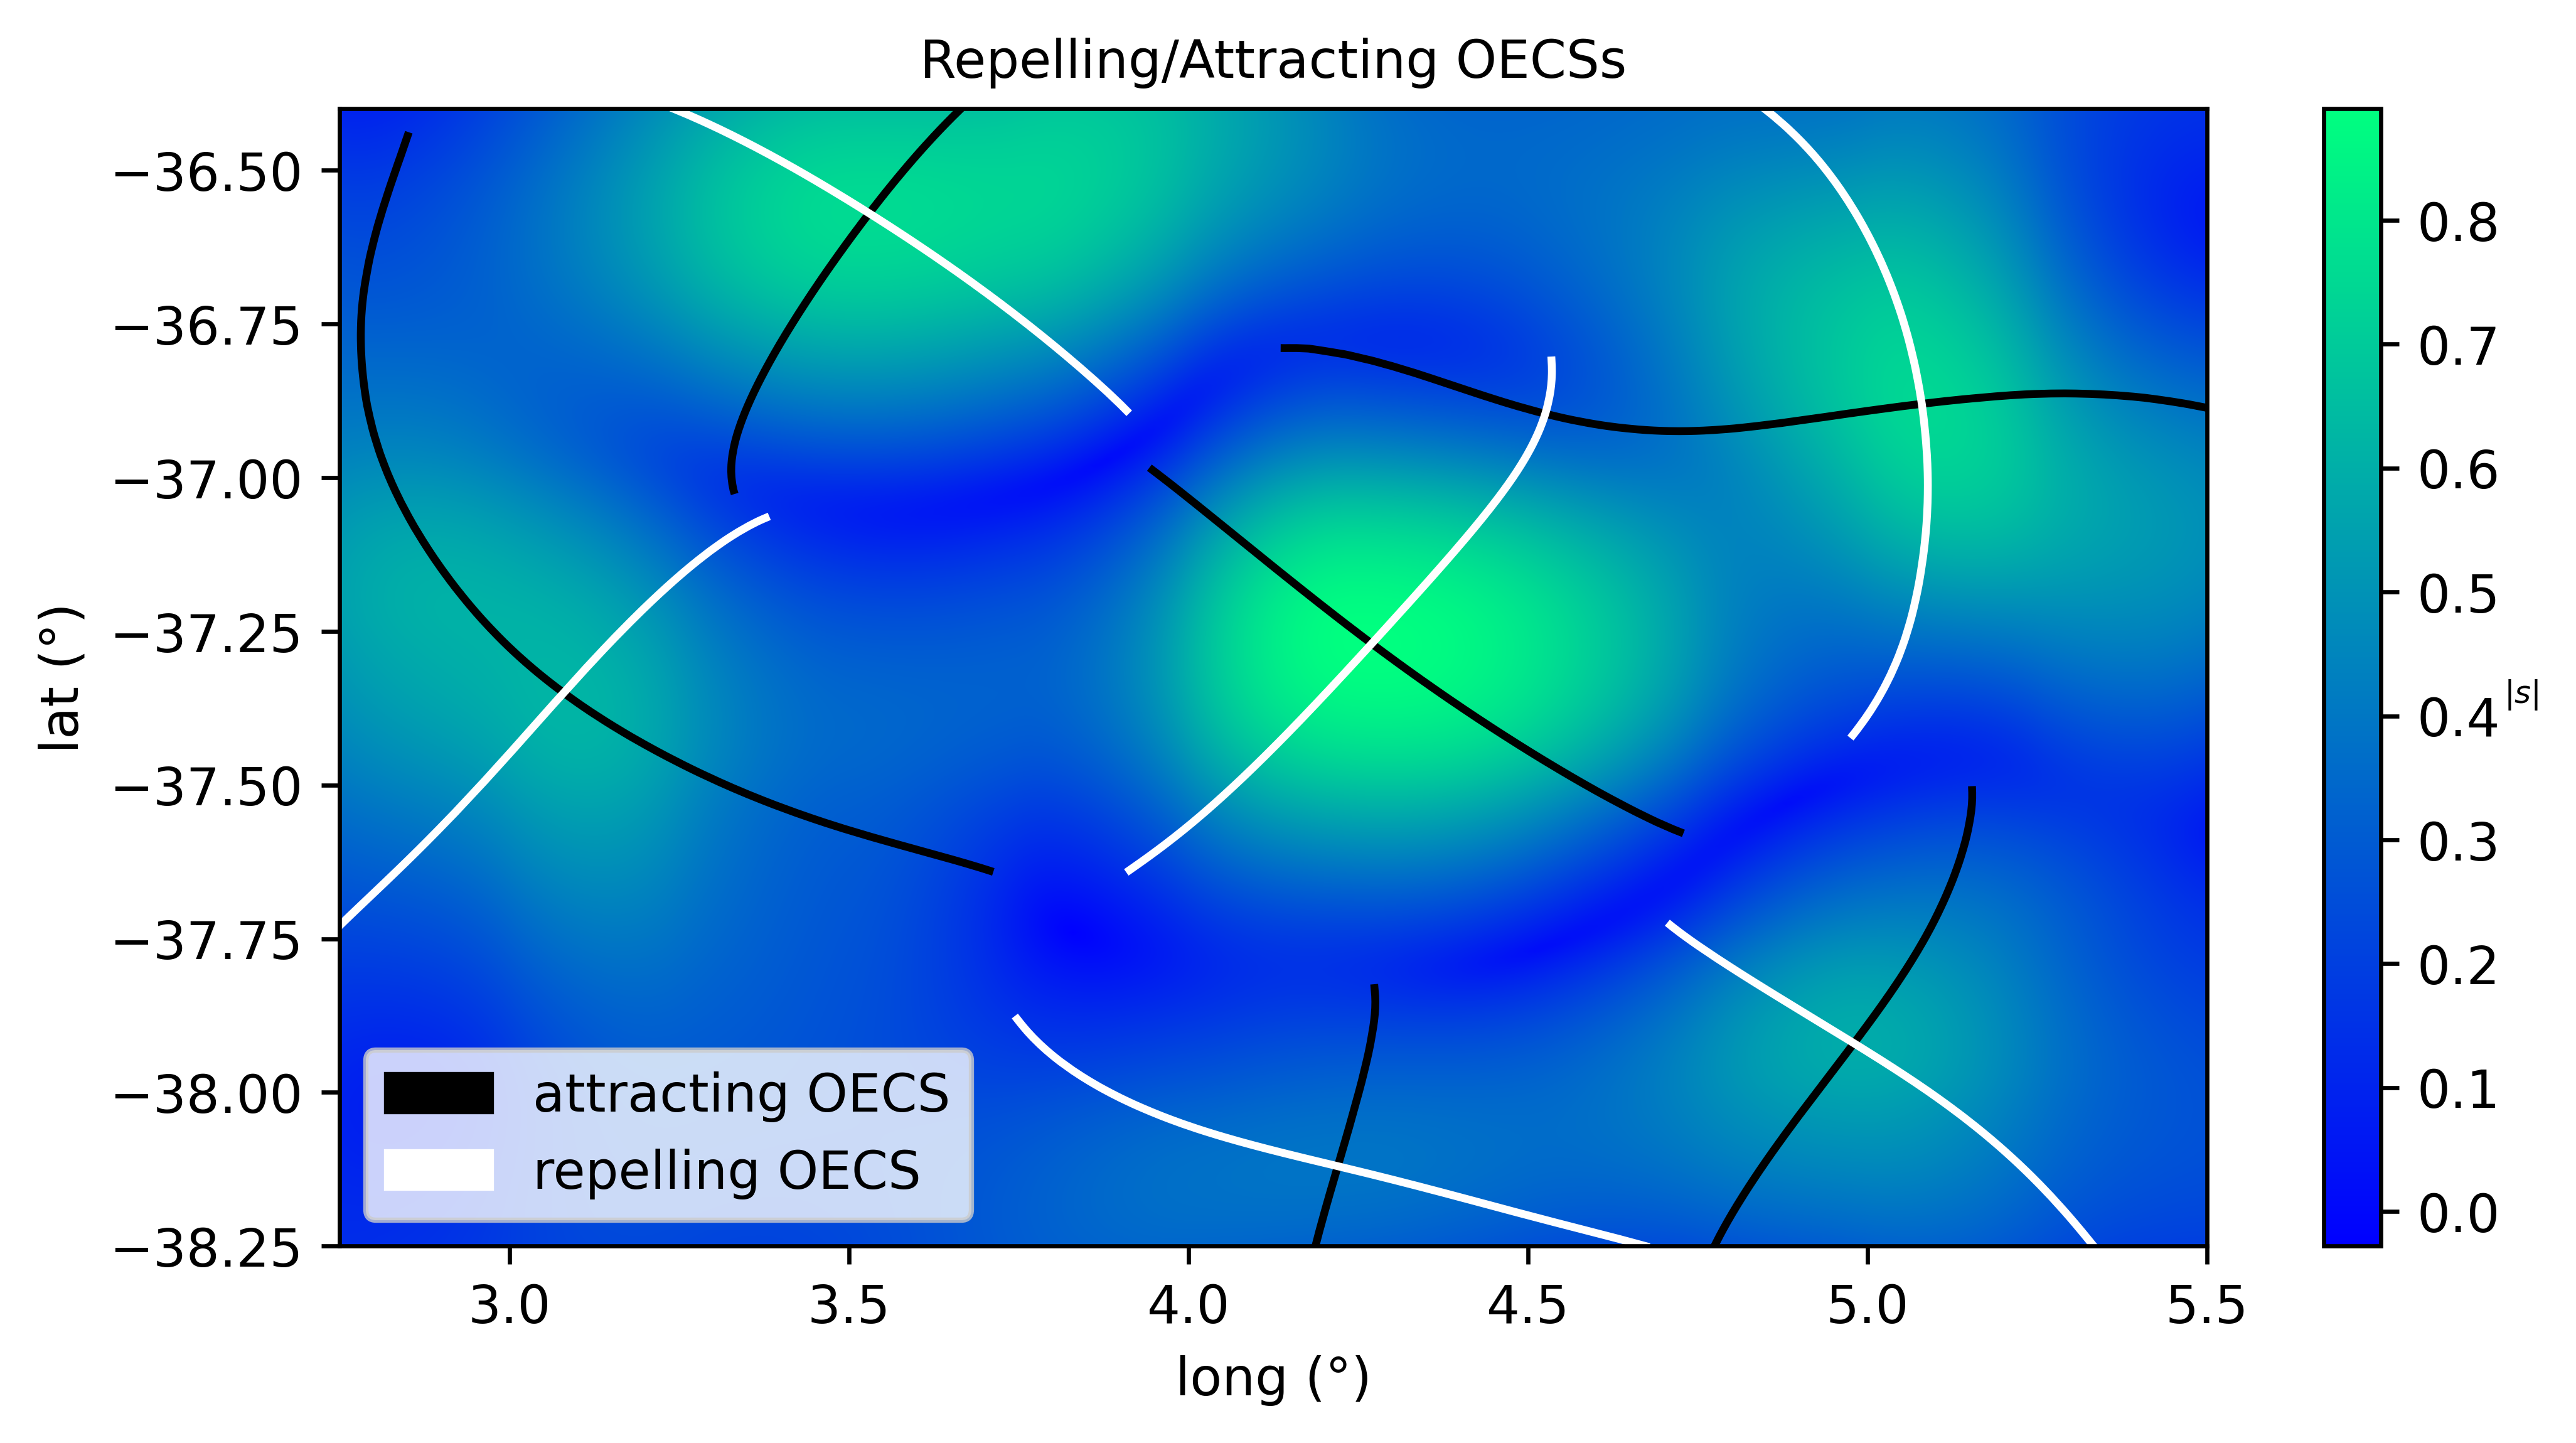

In [12]:
############################################ PLOT RESULTS ############################################

import matplotlib.pyplot as plt

# generate figure and axis object
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Plot eig2-field
cax = ax.contourf(X_domain, Y_domain, eig2, levels = 600, cmap = "winter")

cbar = plt.colorbar(cax)
cbar.set_ticks(np.arange(0, 1.5, 0.1))
cbar.set_label(r'$ |s| $', rotation = 0, fontsize = 6)

# Plot attracting OECS  
for i in range(len(stretchlines[0])):
    ax_attracting = ax.plot(stretchlines[0][i], stretchlines[1][i], c = 'k', linewidth = 1.5)

# Plot repelling OECS
for j in range(len(shrinklines[0])):
    ax_repelling = ax.plot(shrinklines[0][j], shrinklines[1][j], c = "w", linewidth = 1.5)
    
# set limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# set labels
ax.set_xlabel("long (°)")
ax.set_ylabel("lat (°)")

# Set title
ax.set_title('Repelling/Attracting OECSs', fontsize = 10)

# Plot legend
import matplotlib.patches as mpatches
attracting = mpatches.Patch(color='k', label='attracting OECS')
repelling = mpatches.Patch(color='w', label='repelling OECS')
plt.legend(handles=[attracting, repelling], fontsize = 10,  loc = "lower left")
 
# Show plot
plt.show()

Attracting/repelling OECS represent short term attractor/repellors of particles in the flow field. They act as the eulerian counterpart to hyperbolic LCS. Hyperbolic OECS act as a short-term unstable/stable manifold of a saddle point. A comparison with the attracting OECS computed with the [FastTensorlineComputation](../../FastTensorlineComputation/Main) reveals identical structures. 

# References

[1] Serra, M., & Haller, G. (2016). Objective Eulerian coherent structures. Chaos: An Interdisciplinary Journal of Nonlinear Science, 26(5), 053110.

[2] Notebook 5.7.2. in "Transport Barriers and Coherent Structures in Flow Data" by George Haller.